In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class LeNet(nn.Module):
  def __init__(self, in_channels=1,num_classes=10):
    super(LeNet,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=6,kernel_size=5)
    self.batchn2d_1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.batchn2d_2 = nn.BatchNorm2d(16)


    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,num_classes)

  def forward(self, x):
    x=F.relu(self.batchn2d_1(self.conv1(x)))
    #print("x.shape1_conv1")
    #print(x.shape)
    x = F.avg_pool2d(x,2)
    #print("x.shape_pool1")
    #print(x.shape)
    x=F.relu(self.batchn2d_2(self.conv2(x)))
    x = F.avg_pool2d(x,2)
    #print("x.shape_conv2_pool")
    #print(x.shape)
    #x = x.view(-1,self.num_flat_freatures(x))
    x=torch.flatten(x,1)
    #print("x.shape2")
    #print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def num_flat_freatures(self,x):
    size = x.size()[1:]
    num_feat=1
    for s in size:
      num_feat*=s
    return num_feat




In [3]:
model = LeNet(3)
print(model)
input = torch.randn(1,3,32,32)
print(input.shape)

output = model(input)
print(output.shape)
output


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchn2d_1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchn2d_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([1, 3, 32, 32])
torch.Size([1, 10])


tensor([[-0.0831, -0.0477,  0.0590,  0.0412,  0.1213, -0.0133,  0.0253, -0.1015,
          0.0463, -0.1188]], grad_fn=<AddmmBackward0>)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform_train = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [59]:

def validate (model,loss_fn,val_ds,device):
  model.eval()
  val_loss=0
  correct=0
  acc_batch=0

  with torch.no_grad():
    for val_imgs, val_lbls in val_ds:
      val_imgs = val_imgs.to(device)
      val_lbls = val_lbls.to(device)
      outputs = model(val_imgs)
      loss = loss_fn(outputs,val_lbls)
      val_loss+=loss.item()

      _,pred = torch.max(outputs,1)
      correct = ((pred == val_lbls).sum().item())
      acc_batch += correct/val_lbls.size(0)


  avg_acc =acc_batch/len(val_ds)
  avg_loss = val_loss/len(val_ds)
  return avg_loss,avg_acc







In [64]:
net = LeNet(3,10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)
EPOCHS=100

net.to(device)

epoch_loss =[]
epoch_val_loss = []
acc_epoch = []
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    batch_running_losses=0
    batch_i = 0
    net.train()

    for i, inp in enumerate(trainloader):
        batch_i+=1
        inputs, labels = inp
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(next(net.parameters()).is_cuda, inputs.is_cuda, labels.get_device())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_running_losses += loss.item()

        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)

            running_loss = 0.0


    epoch_loss.append(batch_running_losses/batch_i)
    print(f'Loss on epoch [{epoch}] batch size = [{batch_i}] :',batch_running_losses/batch_i)
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    loss_epoch,acc_ = validate(net,criterion,testloader,device=device)
    epoch_val_loss.append(loss_epoch)
    acc_epoch.append(acc_)

print('Training Done')

Loss [1, 100](epoch, minibatch):  2.3171720027923586
Loss [1, 200](epoch, minibatch):  2.2653824210166933
Loss [1, 300](epoch, minibatch):  2.2060995149612426
Loss on epoch [0] batch size = [391] : 2.2293127985561596
Loss [2, 100](epoch, minibatch):  2.1001476430892945
Loss [2, 200](epoch, minibatch):  2.0228456580638885
Loss [2, 300](epoch, minibatch):  1.9526182568073274
Loss on epoch [1] batch size = [391] : 1.9869668312999598
Loss [3, 100](epoch, minibatch):  1.8593602311611175
Loss [3, 200](epoch, minibatch):  1.788264000415802
Loss [3, 300](epoch, minibatch):  1.7827535784244537
Loss on epoch [2] batch size = [391] : 1.7864640783470915
Loss [4, 100](epoch, minibatch):  1.7242952656745911
Loss [4, 200](epoch, minibatch):  1.678313068151474
Loss [4, 300](epoch, minibatch):  1.627690885066986
Loss on epoch [3] batch size = [391] : 1.661132821646493
Loss [5, 100](epoch, minibatch):  1.6005324137210846
Loss [5, 200](epoch, minibatch):  1.5501804649829865
Loss [5, 300](epoch, minibatch

cat


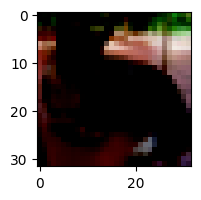

In [13]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

images,labels = next(iter(trainloader))
img = images[0]
img = img.permute(1,2,0)
img = torchvision.utils.make_grid(img)

print(classes[labels[0]])
plt.figure(figsize=(2,2))
plt.imshow(img.numpy())


In [65]:
net.eval()

with torch.no_grad():
  correct=0
  total = 0
  for  imgs, lbls in testloader:
    imgs,lbls =imgs.to(device),lbls.to(device)
    outputs = net(imgs)
    _,pred = torch.max(outputs,1)
    #print(lbls)
    #print(pred)
    correct+=(pred==lbls).sum().item()
    total +=lbls.size(0)


  accuracy = 100 * correct / total
  print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')



Accuracy of the network on the 10000 test images: 67.97 %


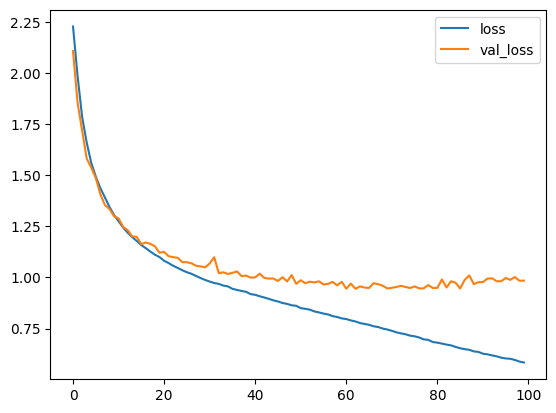

In [66]:
plt.plot(range(EPOCHS),epoch_loss,label='loss')
plt.plot(range(EPOCHS),epoch_val_loss,label='val_loss')
plt.legend()

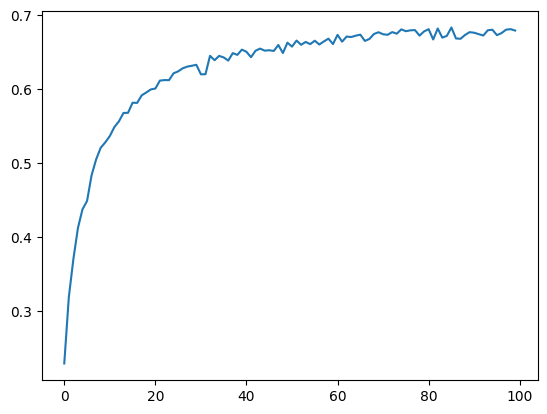

In [67]:
plt.plot(range(EPOCHS),acc_epoch,label='acc')